In [1]:
import tensorflow
import keras
import numpy as np
import pickle
from scipy.sparse import csr_matrix

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [4]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [5]:
with open("../data/adj.pickle",'rb') as f:
    adj = pickle.load(f)

In [6]:
adj = adj.rename(columns={0: 'testcase_ID', 1: 'matrix'})

In [7]:
adj_df = pd.merge(labels, adj, on='testcase_ID')

In [8]:
adj_df = adj_df[['testcase_ID', 'matrix', 'bug']]

Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [9]:
adj_df['matrix_size'] = adj_df.matrix.apply(lambda x: x.shape[0])

In [10]:
adj_df['matrix_size'].describe()

count    21502.000000
mean      2186.138778
std       7239.752920
min          4.000000
25%        349.000000
50%        396.000000
75%        614.000000
max      44401.000000
Name: matrix_size, dtype: float64

So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [11]:
matrix_size = 614
adj_df = adj_df[adj_df['matrix_size'] <= matrix_size]
len(adj_df)

16128

In [12]:
adj_df['matrix'].values[0]

<395x395 sparse matrix of type '<class 'numpy.int64'>'
	with 788 stored elements in Compressed Sparse Row format>

In [13]:
import matplotlib.pyplot as plt

In [14]:
import random

In [15]:
testcase = set(adj_df['testcase_ID'])

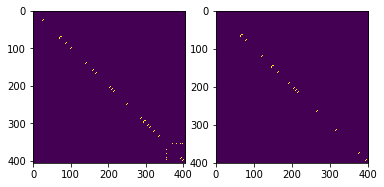

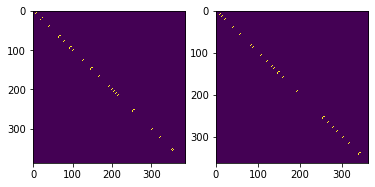

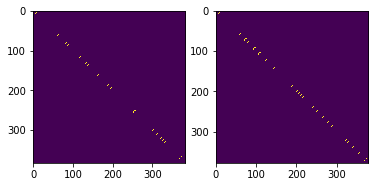

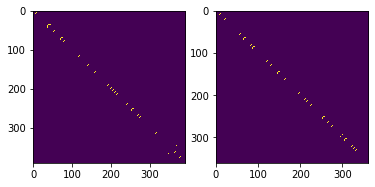

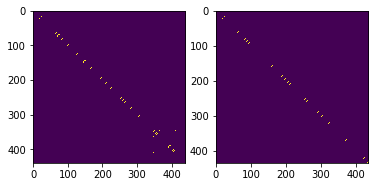

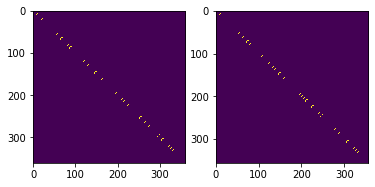

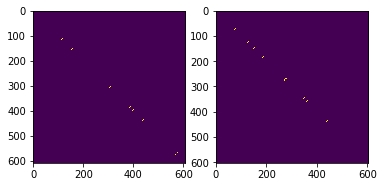

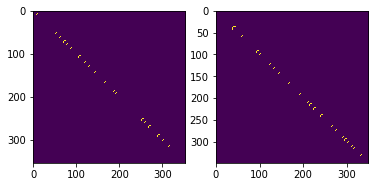

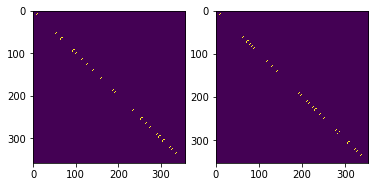

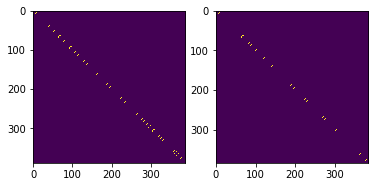

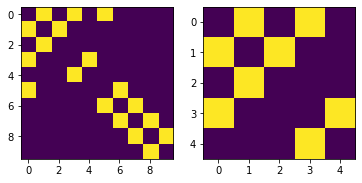

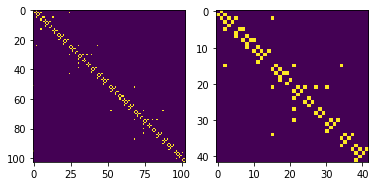

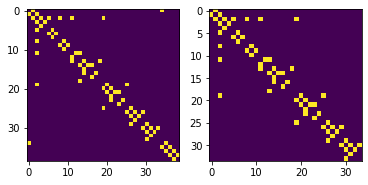

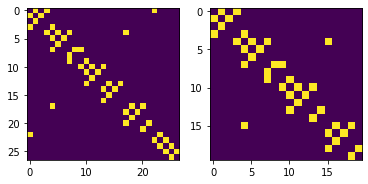

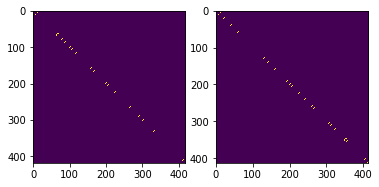

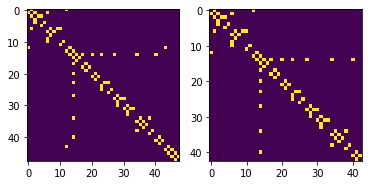

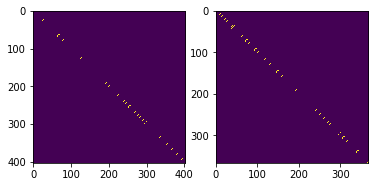

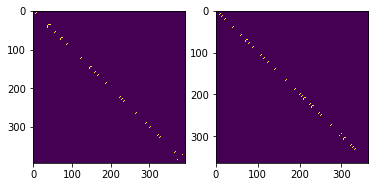

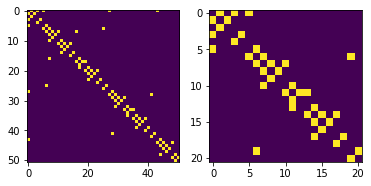

In [16]:
for j in range(1,20):
    i = random.sample(testcase,1)[0]
    # if i is negative then get the positive num
    if i < 0:
        i = -i
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(adj_df.loc[adj_df['testcase_ID'] == i].iloc[0].matrix.toarray())
    plt.subplot(1, 2, 2)
    plt.imshow(adj_df.loc[adj_df['testcase_ID'] == -i].iloc[0].matrix.toarray())
    plt.savefig('../images/%s.png'%(j))

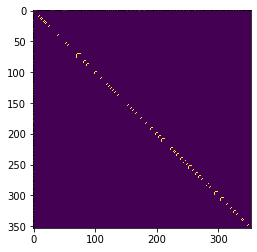

In [64]:
plt.imshow(adj_df['matrix'].values[random.randrange(10000)].toarray())

### Summarising Good & Bad Adjacency Matrices

In this section we investigate the distribution of the buggy and non-buggy adjacency matrices. Can we find a meaningful difference?

Start by padding all matrices to the same size, group them by good and bad, then sum each group cell wise to produce a two dimensional histogram.

In [25]:
from scipy.sparse import csr_matrix, hstack, vstack

In [26]:
def matrix_size_corrector(matrix, size):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((size-rows, rows))
    col_corrector = csr_matrix((size, size-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix

In [27]:
padded_matrices = adj_df.copy()
padded_matrices['matrix'] = padded_matrices['matrix'].apply(lambda m: matrix_size_corrector(m, matrix_size))

In [28]:
good_matrices = padded_matrices[padded_matrices['bug'] == False]['matrix']
bad_matrices = padded_matrices[padded_matrices['bug'] == True]['matrix']

In [30]:
good_summary = good_matrices.sum()
bad_summary = bad_matrices.sum()

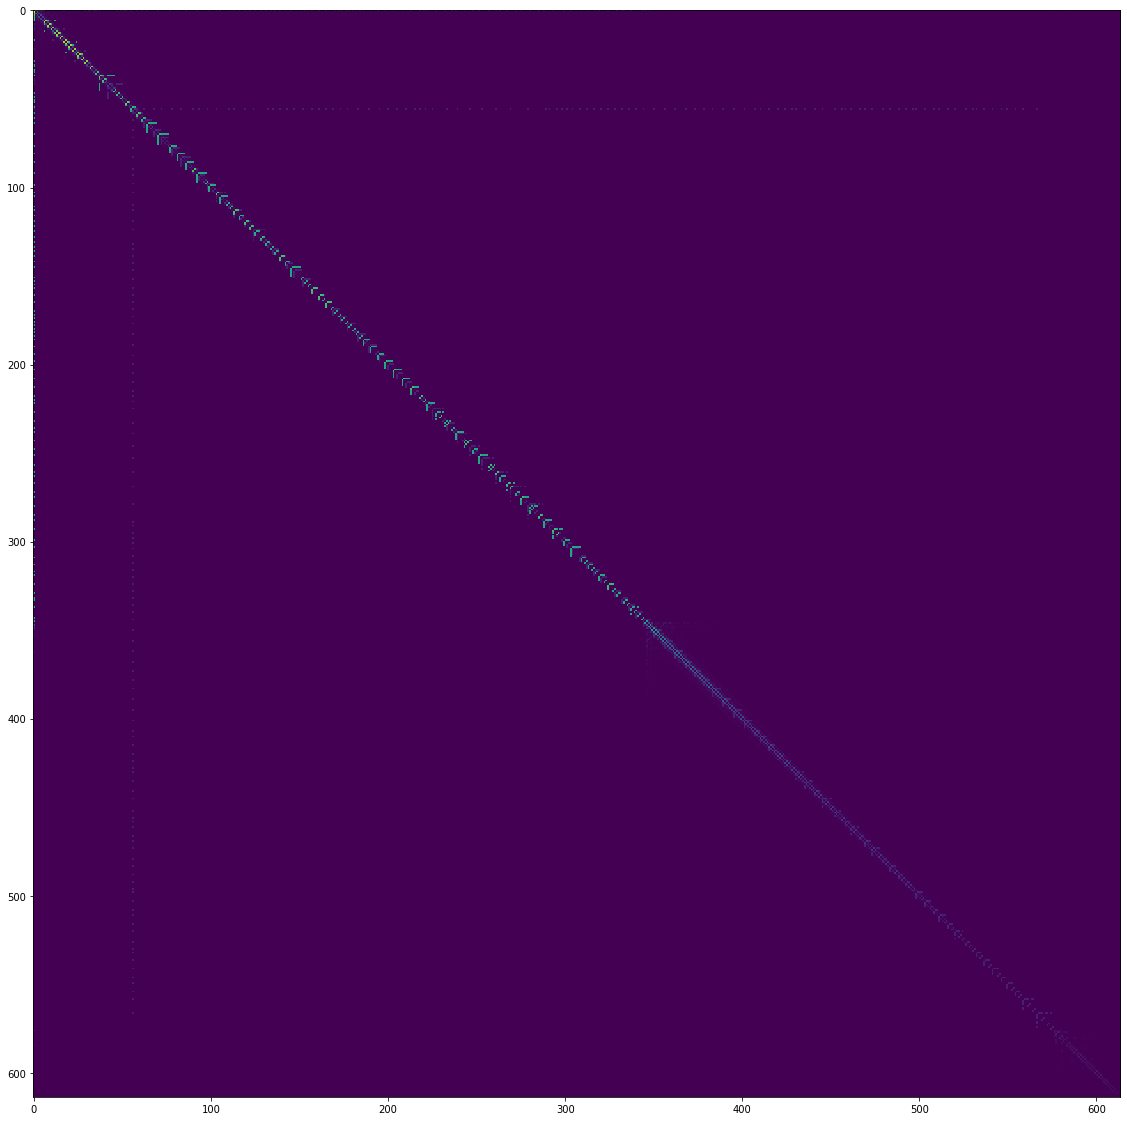

In [40]:
fig, axes = plt.subplots()
fig.set_size_inches(20, 20)
plt.imshow(good_summary.todense())

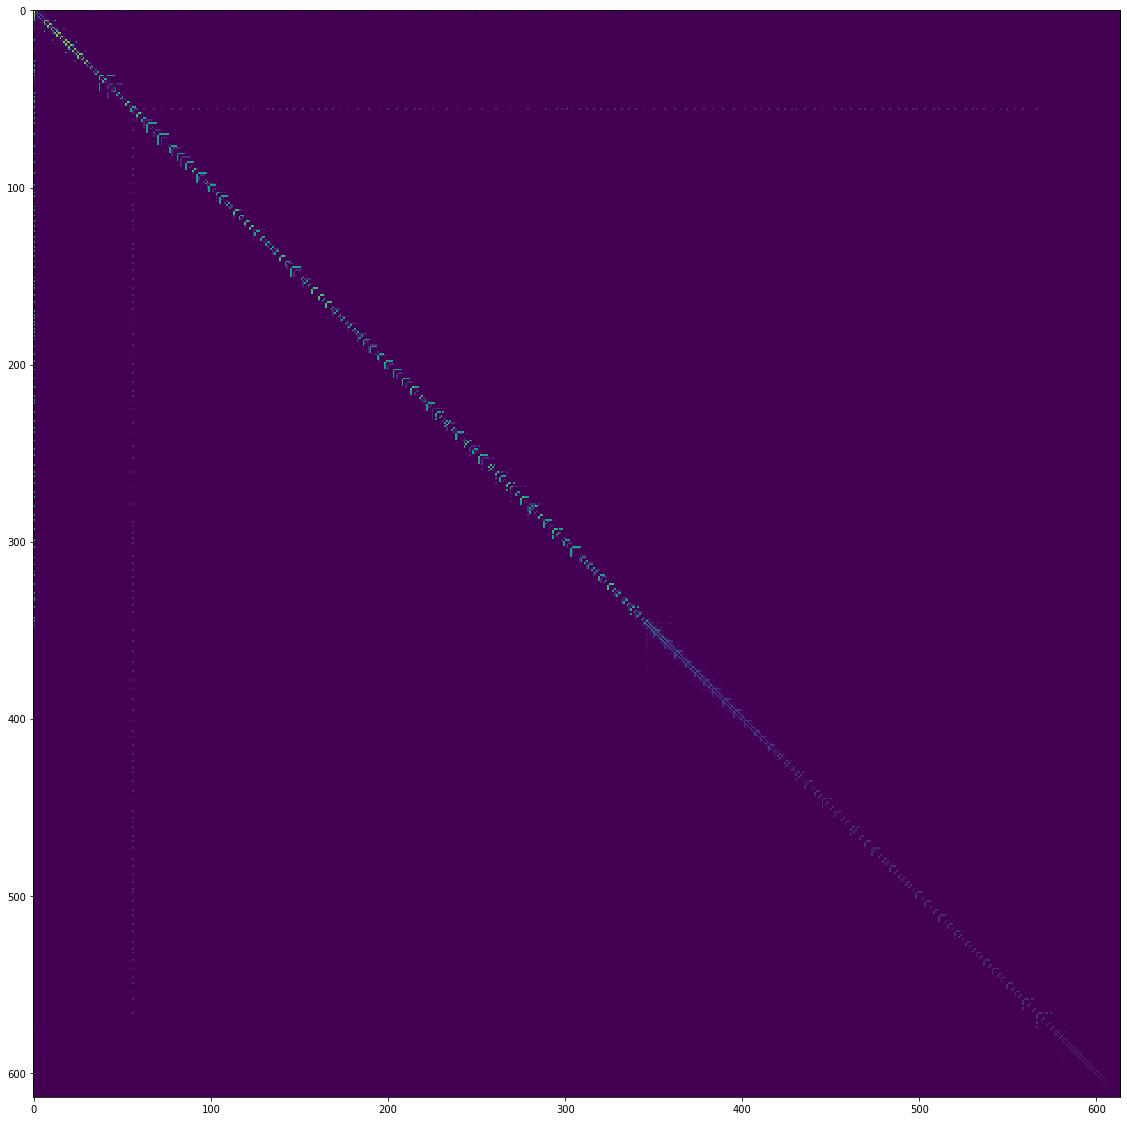

In [42]:
fig, axes = plt.subplots()
fig.set_size_inches(20, 20)
plt.imshow(bad_summary.todense())

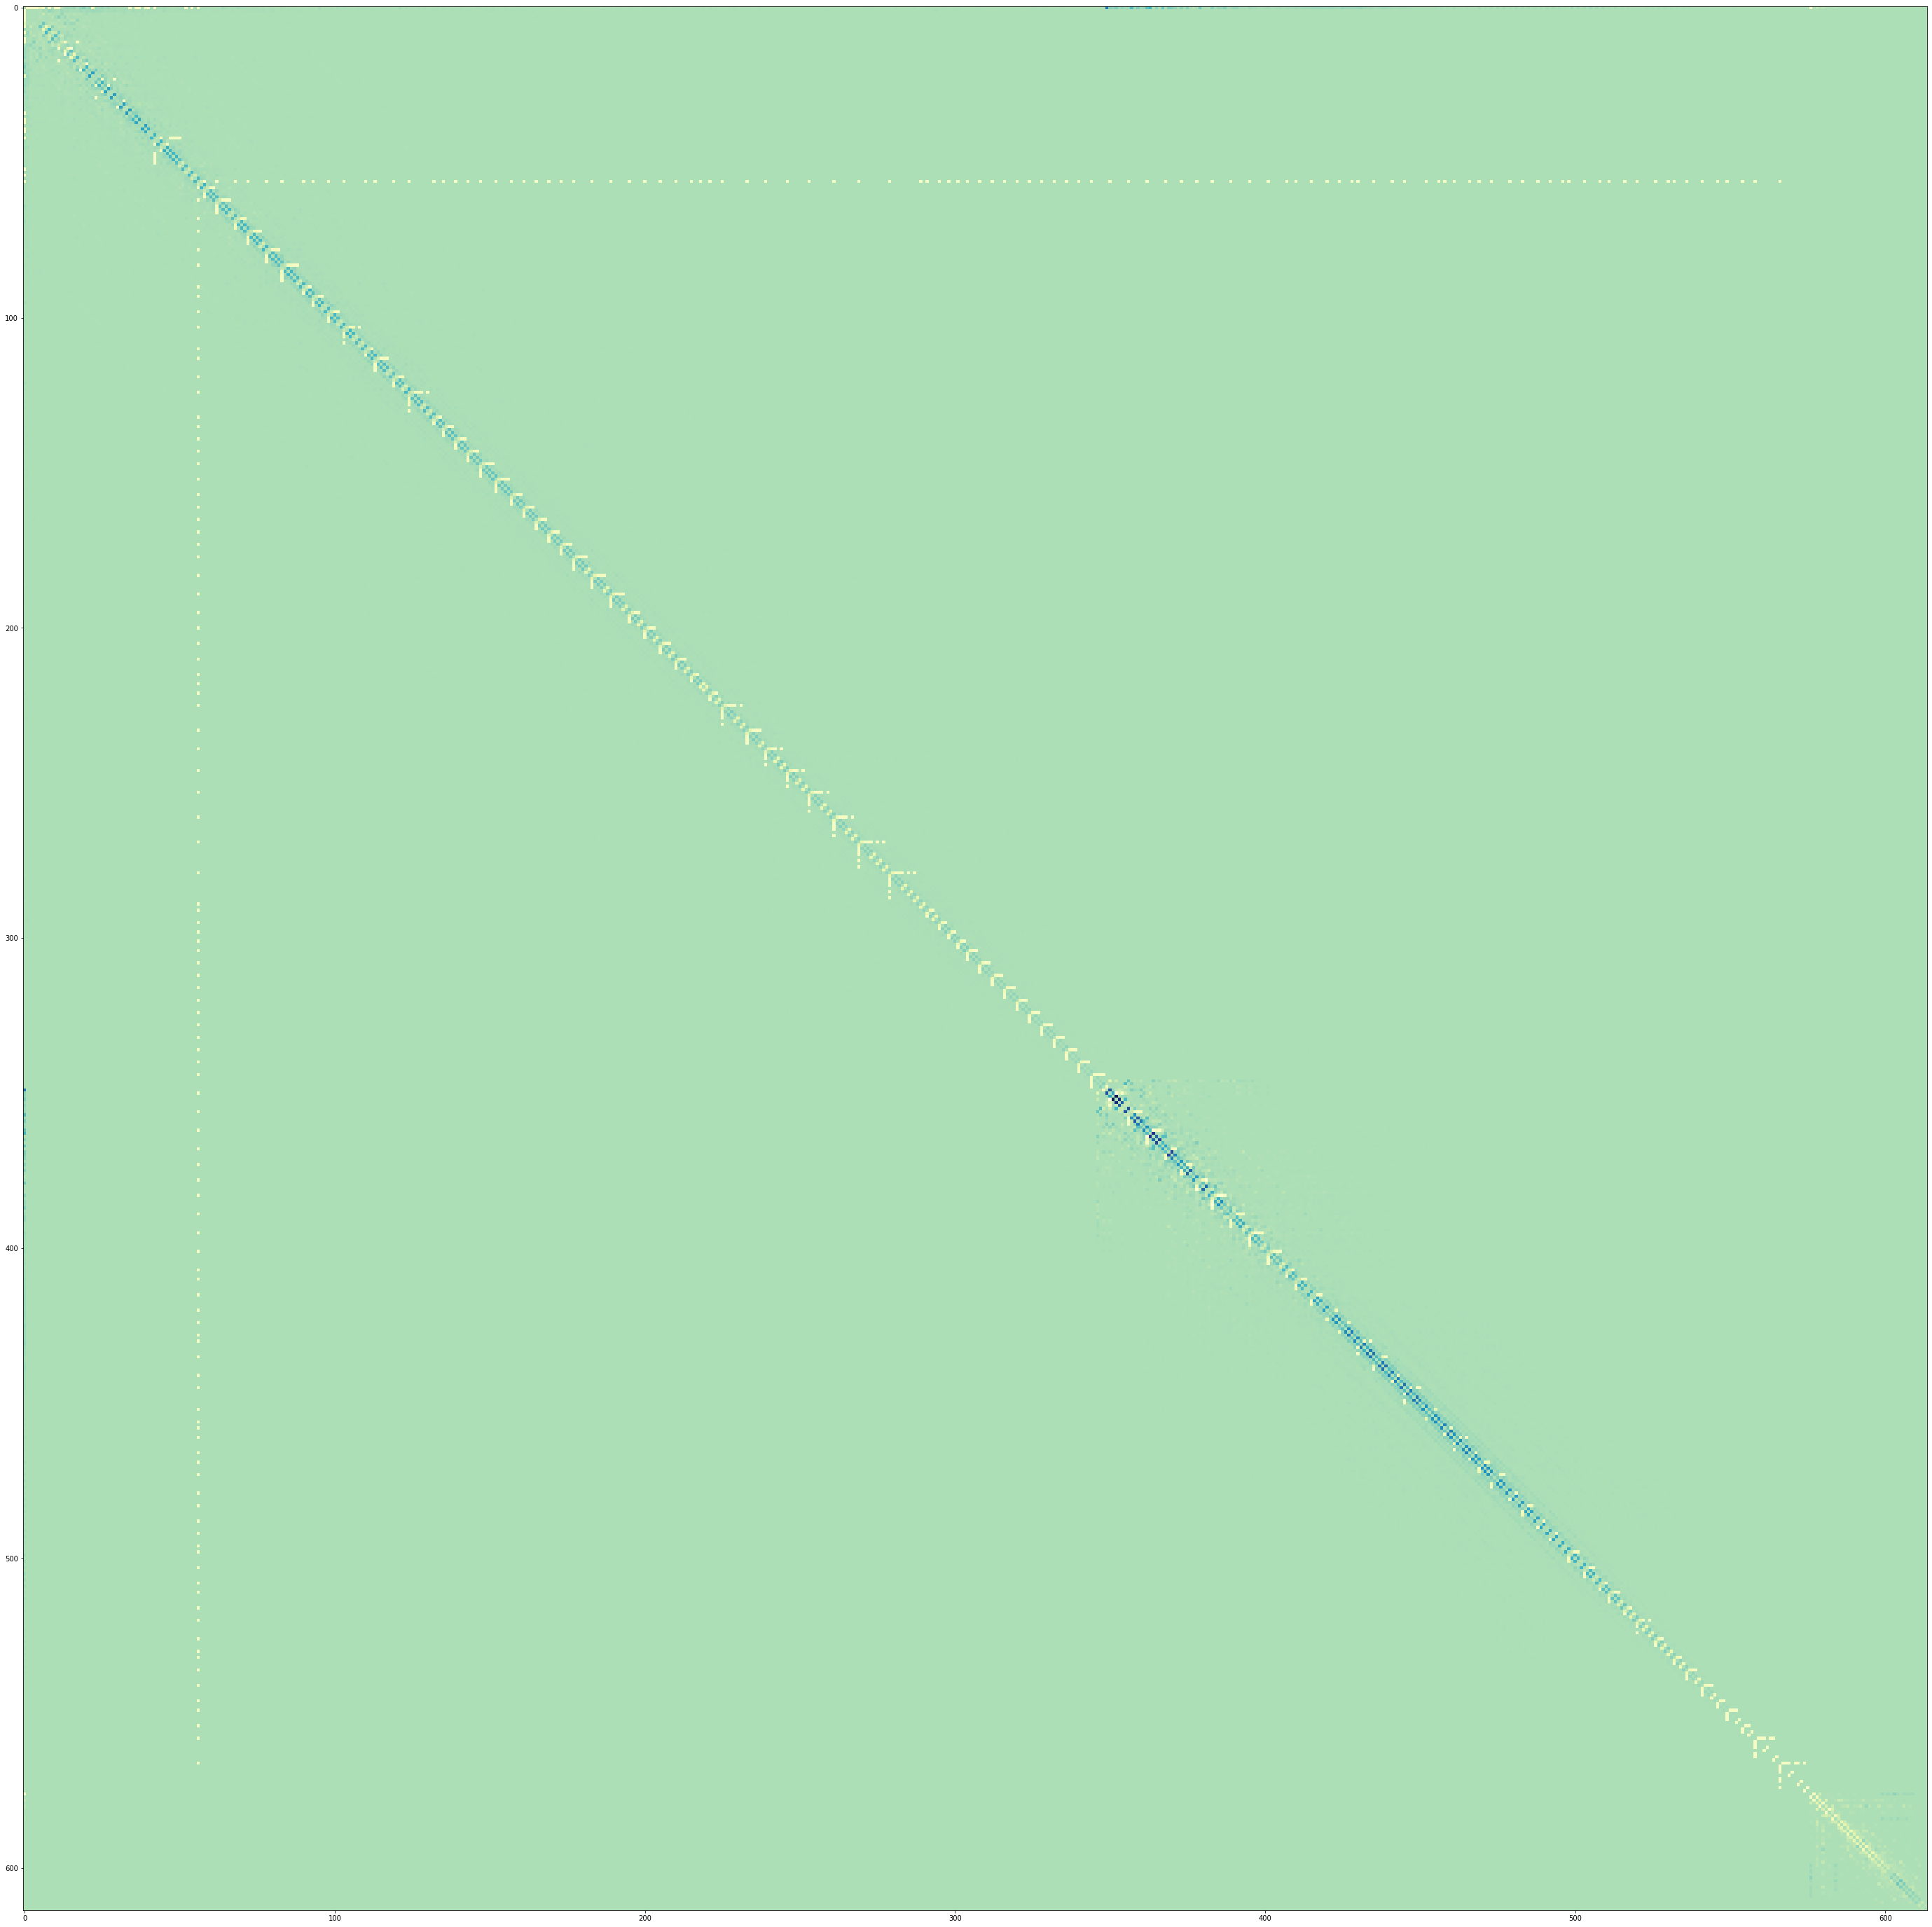

In [70]:
fig, axes = plt.subplots()
fig.set_size_inches(50, 50)
plt.imshow(good_summary.todense() - bad_summary.todense(), cmap='YlGnBu')